In [1]:
import sys
import platform

print(sys.version)
print(platform.processor())

3.8.2 (tags/v3.8.2:7b3ab59, Feb 25 2020, 23:03:10) [MSC v.1916 64 bit (AMD64)]
Intel64 Family 6 Model 142 Stepping 12, GenuineIntel


# Local optimization algorithms

In [2]:
from collections import defaultdict
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from src.algorithms.two_opt import TwoOpt
from src.algorithms.three_opt import ThreeOpt
from src.algorithms.lk_opt import LKOpt
from src.algorithms.lkh_opt import LKHOpt

from src.algorithms.structures.matrix import adjacency_matrix
from src.algorithms.utils.generator import generator
from src.algorithms.utils.initial_tour import greedy

In [50]:
pd.options.display.float_format = '{:.2f}'.format

def generate_data(size, tries):
    data = []
    for _ in range(tries):
        tsp = generator(size)
        matrix = adjacency_matrix(tsp)
        length, tour = greedy(matrix)
        data.append((length, tour, matrix))
    return data

def generate_results(optimizer, data, **kwargs):
    all_frames = None
    for length, tour, matrix in data:
        opt = optimizer(length, tour.copy(), matrix.copy(), collect=True, **kwargs)
        opt.optimize()

        frame = opt.collector.as_frame()
        frame['time'] = frame['time'] - frame['time'][1]
        frame = frame[1:]
        if all_frames is None:
            all_frames = frame
        else:
            all_frames = all_frames.append(frame)
    return all_frames

def draw_x_y(frames, labels, x, y):
    for i in range(len(frames)):
        plt.scatter(frames[i][x], frames[i][y], s=1, marker='.', label=labels[i])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid('both')
    plt.legend()
    plt.show()
    
def draw_i_y(frames, labels, y):
    for i in range(len(frames)):
        plt.scatter(frames[i].index, frames[i][y], s=1, marker='.', label=labels[i])
    plt.xlabel('iteration')
    plt.ylabel(y)
    plt.grid('both')
    plt.legend()
    plt.show()

## General view for all optimizations

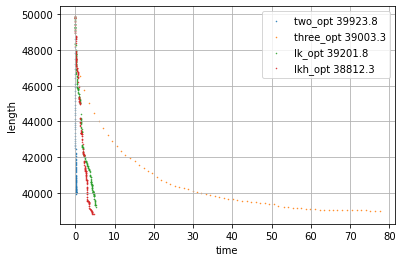

In [7]:
data = generate_data(500, 1)
two_opt = generate_results(TwoOpt, data, )
three_opt = generate_results(ThreeOpt, data, )
lk_opt = generate_results(LKOpt, data,)
lkh_opt = generate_results(LKHOpt, data)

opts = [two_opt, three_opt, lk_opt, lkh_opt]
names = [f"two_opt {two_opt['length'].min():0.1f}", 
         f"three_opt {three_opt['length'].min():0.1f}",
         f"lk_opt {lk_opt['length'].min():0.1f}", 
         f"lkh_opt {lkh_opt['length'].min():0.1f}"]

draw_x_y(opts, names, 'time', 'length')

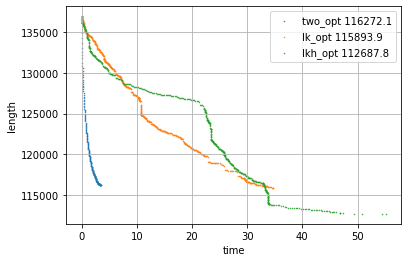

In [9]:
data = generate_data(1500, 1)
two_opt = generate_results(TwoOpt, data, )
lk_opt = generate_results(LKOpt, data,)
lkh_opt = generate_results(LKHOpt, data)

opts = [two_opt, lk_opt, lkh_opt]
names = [f"two_opt {two_opt['length'].min():0.1f}", 
         f"lk_opt {lk_opt['length'].min():0.1f}", 
         f"lkh_opt {lkh_opt['length'].min():0.1f}"]

draw_x_y(opts, names, 'time', 'length')

## On the average

### Length

In [37]:
def run(optimizer, frame, name, length, tour, matrix, **kwargs):
    opt = optimizer(length, tour.copy(), matrix.copy(), **kwargs)
    opt.optimize()
    frame[name].append(100 - opt.length / (length / 100))

n = 25
length_frame = defaultdict(list)
tests = [25, 50, 100, 250]
length_frame['tests'] = tests

for size in tests:
    frame = defaultdict(list)
    samples = generate_data(size, n)
    for length, tour, matrix in samples:
        run(TwoOpt, frame, 'two_opt', length, tour, matrix)
        run(ThreeOpt, frame, 'three_opt', length, tour, matrix)
        run(LKOpt, frame, 'lk_opt', length, tour, matrix)
        run(LKHOpt, frame, 'lkh_opt', length, tour, matrix)
    frame = pd.DataFrame(frame)
    length_frame['two_opt'].append(frame['two_opt'].mean())
    length_frame['three_opt'].append(frame['three_opt'].mean())
    length_frame['lk_opt'].append(frame['lk_opt'].mean())
    length_frame['lkh_opt'].append(frame['lkh_opt'].mean())
    
length_frame = pd.DataFrame(length_frame)
print('Better then initial (%):') 
print(length_frame)

Better then initial (%):
   tests    two_opt  three_opt     lk_opt    lkh_opt
0     25  14.148681  15.359959  14.348140  14.462229
1     50  15.867763  17.292601  15.883846  16.673964
2    100  16.661100  19.285731  17.479417  19.073269
3    250  16.358437  18.542693  17.798410  18.350230


### Time

In [43]:
def run(optimizer, frame, name, length, tour, matrix, **kwargs):
    t_start = time()
    opt = optimizer(length, tour.copy(), matrix.copy(), **kwargs)
    opt.optimize()
    frame[name].append(time() - t_start)

n = 25
time_frame = defaultdict(list)
tests = [25, 50, 100, 250]
time_frame['tests'] = tests

for size in tests:
    frame = defaultdict(list)
    samples = generate_data(size, n)
    for length, tour, matrix in samples:
        run(TwoOpt, frame, 'two_opt', length, tour, matrix)
        run(ThreeOpt, frame, 'three_opt', length, tour, matrix)
        run(LKOpt, frame, 'lk_opt', length, tour, matrix)
        run(LKHOpt, frame, 'lkh_opt', length, tour, matrix)
    frame = pd.DataFrame(frame)
    time_frame['three_opt'].append((frame['three_opt'] - frame['two_opt']).mean())
    time_frame['lk_opt'].append((frame['lk_opt'] - frame['two_opt']).mean())
    time_frame['lkh_opt'].append((frame['lkh_opt'] - frame['two_opt']).mean())
    
time_frame = pd.DataFrame(time_frame)
print('Worse then two opt (sec):') 
print(time_frame)

Worse then two opt (sec):
   tests  three_opt    lk_opt   lkh_opt
0     25   0.000398  0.007032  0.010640
1     50   0.009245  0.030084  0.039000
2    100   0.133731  0.117323  0.176473
3    250   5.093341  0.778141  1.008129


### Iterations

In [46]:
def run(optimizer, frame, name, length, tour, matrix, **kwargs):
    opt = optimizer(length, tour.copy(), matrix.copy(), collect=True, **kwargs)
    opt.optimize()
    frame[name].append(len(opt.collector.as_frame()))

n = 25
iterations_frame = defaultdict(list)
tests = [25, 50, 100, 250]
iterations_frame['tests'] = tests

for size in tests:
    frame = defaultdict(list)
    samples = generate_data(size, n)
    for length, tour, matrix in samples:
        run(TwoOpt, frame, 'two_opt', length, tour, matrix)
        run(ThreeOpt, frame, 'three_opt', length, tour, matrix)
        run(LKOpt, frame, 'lk_opt', length, tour, matrix)
        run(LKHOpt, frame, 'lkh_opt', length, tour, matrix)
    frame = pd.DataFrame(frame)
    iterations_frame['two_opt'].append(frame['two_opt'].mean())
    iterations_frame['three_opt'].append(frame['three_opt'].mean())
    iterations_frame['lk_opt'].append(frame['lk_opt'].mean())
    iterations_frame['lkh_opt'].append(frame['lkh_opt'].mean())
    
iterations_frame = pd.DataFrame(iterations_frame)
print('Iterations:') 
print(iterations_frame)

Iterations:
   tests  two_opt  three_opt  lk_opt  lkh_opt
0     25     6.32       4.72    9.68     9.56
1     50    11.12       8.76   21.68    21.44
2    100    21.28      15.96   39.60    37.36
3    250    44.24      36.08   99.96    93.32


## Lin-Kernighan

In [122]:
def runner(optimizer, frame, value, length, tour, matrix, **kwargs):
    t_start = time()
    opt = optimizer(length, tour.copy(), matrix.copy(), **kwargs)
    opt.optimize()
    frame[f'{value}time'].append(time() - t_start)
    frame[f'{value}length'].append(100 - opt.length / (length / 100))
    
def executor(opt, tests, values, parameter, n):
    length_frame = defaultdict(list)
    time_frame = defaultdict(list)
    
    for size in tests:
        frame = defaultdict(list)
        samples = generate_data(size, n)
        for length, tour, matrix in samples:
            for value in values:
                kwargs = {parameter: value}
                runner(opt, frame, value, length, tour, matrix, **kwargs)
        frame = pd.DataFrame(frame)
        for value in values:
            length_frame[f'{parameter}={value}'].append(frame[f'{value}length'].mean())
            time_frame[f'{parameter}={value}'].append(frame[f'{value}time'].mean())
            
    print('-----')
    length_frame = pd.DataFrame(length_frame)
    time_frame = pd.DataFrame(time_frame)
    print('Better then initial (%):') 
    print(length_frame)
    print('Time (s)')
    print(time_frame)  

### K-opt

In [123]:
executor(LKOpt, [25, 50, 100, 200, 400], [3, 5, 7, 9, 11], 'k', 10)

-----
Better then initial (%):
    k=3   k=5   k=7   k=9  k=11
0 15.51 15.34 15.34 15.34 15.34
1 15.91 16.63 16.96 17.20 17.15
2 13.74 15.43 15.38 15.45 15.46
3 16.88 17.72 17.98 18.78 18.33
4 16.79 17.26 17.35 18.13 17.86
Time (s)
   k=3  k=5  k=7  k=9  k=11
0 0.00 0.01 0.01 0.01  0.01
1 0.02 0.03 0.03 0.04  0.04
2 0.05 0.08 0.12 0.15  0.18
3 0.33 0.65 1.09 2.01  4.51
4 1.22 2.23 3.82 5.97  7.46


### Neighbours

In [124]:
executor(LKOpt, [25, 50, 100, 200, 400], [5, 10, 15, 20], 'neighbours', 10)

-----
Better then initial (%):
   neighbours=5  neighbours=10  neighbours=15  neighbours=20
0         14.88          15.70          15.63          15.63
1         16.74          17.75          17.23          17.33
2         18.07          19.47          19.65          19.51
3         17.02          18.64          18.70          18.75
4         17.70          18.88          19.14          19.06
Time (s)
   neighbours=5  neighbours=10  neighbours=15  neighbours=20
0          0.01           0.01           0.02           0.02
1          0.03           0.07           0.09           0.09
2          0.11           0.23           0.32           0.33
3          0.59           1.23           1.44           2.05
4          2.44           7.20           5.65           7.03


### With / Without: DLB

In [125]:
executor(LKOpt, [25, 50, 100, 200, 400], [True, False], 'dlb', 10)

-----
Better then initial (%):
   dlb=True  dlb=False
0     18.85      18.88
1     17.47      17.81
2     16.52      17.58
3     16.29      17.95
4     16.76      16.43
Time (s)
   dlb=True  dlb=False
0      0.01       0.01
1      0.02       0.03
2      0.08       0.15
3      0.28       0.51
4      1.39       2.41


### With / With Fast / Without: Double Bridge

In [126]:
executor(LKOpt, [25, 50, 100, 200, 400], [(2, False), (2, True), (0, False)], 'bridge', 10)

-----
Better then initial (%):
   bridge=(2, False)  bridge=(2, True)  bridge=(0, False)
0              12.26             12.26              12.01
1              16.73             16.73              15.70
2              17.00             16.91              16.14
3              16.03             16.05              15.93
4              17.57             17.58              17.35
Time (s)
   bridge=(2, False)  bridge=(2, True)  bridge=(0, False)
0               0.01              0.01               0.01
1               0.03              0.03               0.03
2               0.11              0.10               0.09
3               0.60              0.65               0.60
4               2.84              2.72               2.66


## Lin-Kernighan-Helsgaun

### K-opt

In [127]:
executor(LKHOpt, [25, 50, 100, 200, 400], [3, 5, 7, 9, 11], 'k', 10)

-----
Better then initial (%):
    k=3   k=5   k=7   k=9  k=11
0 14.40 14.55 14.82 15.07 15.07
1 15.26 15.32 16.19 16.30 15.80
2 18.47 18.70 19.00 19.30 19.24
3 16.41 16.75 17.25 16.95 17.43
4 18.37 19.11 19.18 19.36 19.27
Time (s)
   k=3  k=5  k=7  k=9  k=11
0 0.01 0.01 0.01 0.02  0.03
1 0.03 0.03 0.04 0.07  0.13
2 0.11 0.12 0.17 0.22  0.23
3 0.41 0.52 0.60 0.90  1.20
4 2.02 2.39 3.12 4.34  6.68


### With / Without Subgradient

In [128]:
executor(LKHOpt, [25, 50, 100, 200, 400], [True, False], 'subgradient', 10)

-----
Better then initial (%):
   subgradient=True  subgradient=False
0             12.50              11.55
1             15.22              15.31
2             17.03              17.03
3             17.21              17.07
4             19.05              18.75
Time (s)
   subgradient=True  subgradient=False
0              0.04               0.01
1              0.07               0.04
2              0.28               0.18
3              1.01               0.59
4              4.89               2.81


### Mul for excess

In [129]:
executor(LKHOpt, [25, 50, 100, 200, 400], [1, 2, 3], 'mul', 10)

-----
Better then initial (%):
   mul=1  mul=2  mul=3
0  13.54  13.89  13.89
1  13.54  14.16  14.11
2  17.38  17.40  17.24
3  17.30  17.28  17.63
4  17.81  18.43  18.40
Time (s)
   mul=1  mul=2  mul=3
0   0.01   0.01   0.01
1   0.02   0.04   0.06
2   0.07   0.16   0.29
3   0.36   0.66   1.47
4   1.90   3.12   7.02


### With / Without Non Seq

In [130]:
executor(LKHOpt, [25, 50, 100, 200, 400], [True, False], 'non_seq', 10)

-----
Better then initial (%):
   non_seq=True  non_seq=False
0         13.18          13.18
1         14.90          14.46
2         18.72          18.20
3         18.49          17.91
4         19.23          18.92
Time (s)
   non_seq=True  non_seq=False
0          0.12           0.01
1          0.87           0.04
2          3.98           0.16
3         16.01           0.60
4         54.66           3.24
